# Stock Prediction Using Data From Yahoo Finance

### Table of contents 
1. Acknowledgments
2. Imports
2. EDA
3. Feature Engineering
1. Base line: prices are the same as the year before.
2. Linear model
3. Polynomial models
3. KNN
4. CNN
4. LSTM

#### Acknowledgements:
- https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
- https://towardsdatascience.com/keep-it-simple-keep-it-linear-a-linear-regression-model-for-time-series-5dbc83d89fc3

#### Import and Function defenitions

In [1]:
from pandas_datareader import data as web
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import date
import yfinance as yf
import seaborn as sns
from math import sqrt
import pandas as pd
import numpy as np
import IPython
import IPython.display

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import prophet
import tensorflow as tf
from fbprophet import Prophet

import math
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
yf.pdr_override()

In [2]:
def get_data(ticker):
    """
    INPUT: ticker - (str) ticker of a stock to be predicted
    
    OUTPUT: data - (pandas dataframe) dataframe with stock price info. 
            Includes following columns: 
                - Open
                - High
                - Low
                - Close
                - Adj Close
                - Volume
    """
    
    today = date.today()
    
    data = web.get_data_yahoo(ticker, end = today)
    
    return data

In [3]:
def line_plot(df, col_name, title):
    """
    INPUT: df - (pandas dataframe) dataframe that contains data to be ploted
           col_name - (string) column to be ploted
           ticker - (string) company stock ticker 

    OUTPUT: N/A
    """
    plt.figure(figsize=(14, 8))
    df[col_name].plot()
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(title)
    plt.show()

In [69]:
def compute_errors(y_test, predictions):
    """
    INPUT: y_test - (list) prediction values
           predictions - (list) prediction values

    OUTPUT: print MSE, RMSE, MAPE
    """
    # Compute errors
    mse_base = mean_squared_error(y_test, predictions)
    rmse_base = np.sqrt(mse_base)
    mape = mean_absolute_percentage_error(y_test, predictions)

    print('Mean squared error of a model is ', mse_base)
    print('Root mean squared error of a model is ', rmse_base)
    print('Mean absolute percentage error of a model is ', mape)


## Get the Data

At this step I will get user input for the ticker and load coresponding stock prices data from Yahoo Finance.

In [5]:
ticker = input()

 GOOG


In [6]:
# load the data
try:
    df = get_data(ticker)
except Exception:
    print('Data can not be loaded. Please check your ticker and try again')

[*********************100%***********************]  1 of 1 completed


In [7]:
# subset the dataset
df = df[df.index > '1999-12-31']

## Data Exploration

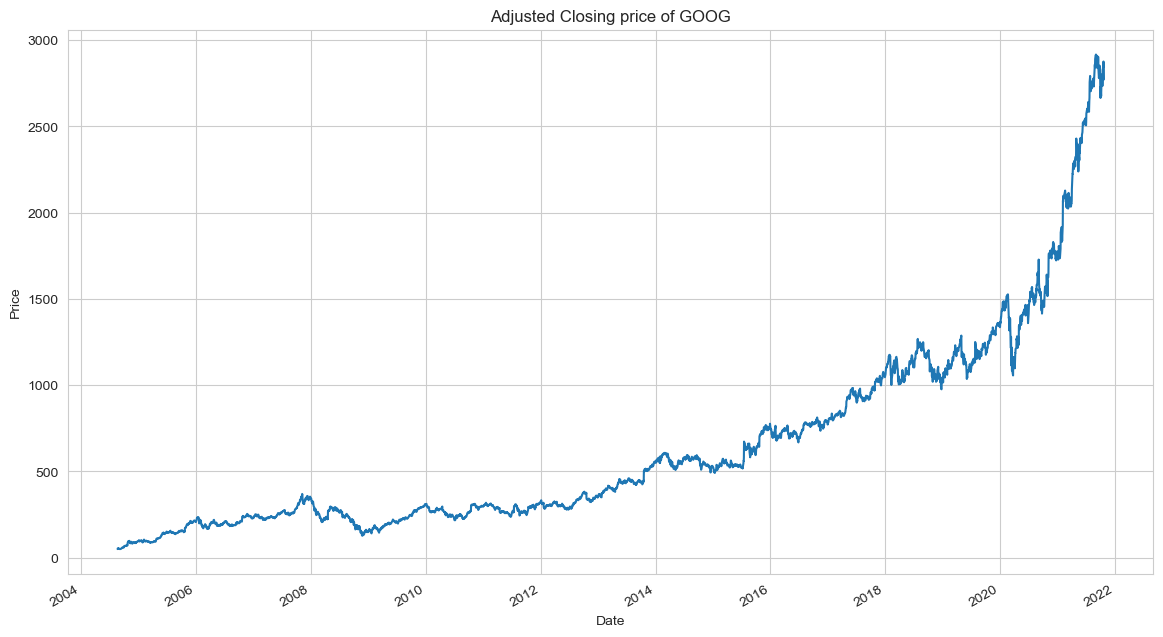

In [8]:
# plot closing price column (value we will try to predict)
line_plot(df, 'Adj Close', "Adjusted Closing price of {}".format(ticker))

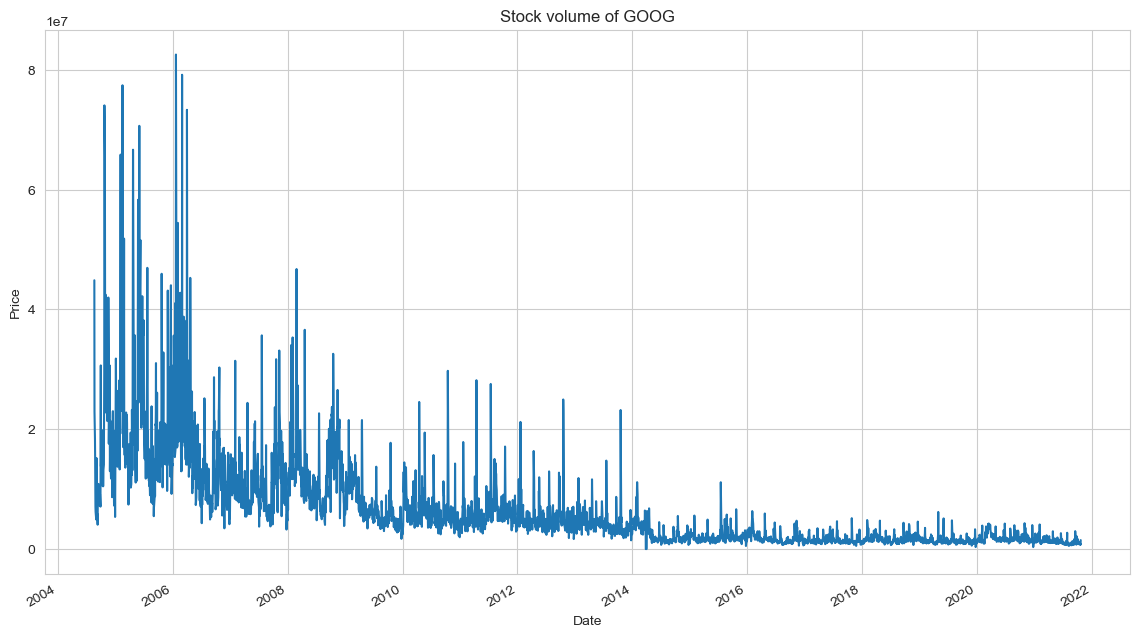

In [9]:
# plot stock volume
line_plot(df, 'Volume', 'Stock volume of {}'.format(ticker))

In [10]:
sns.heatmap(df[['Adj Close', 'Volume']].corr())

<AxesSubplot:>

## Feature Engineering

Reference: https://alphascientist.com/feature_engineering.html

In [11]:
df.loc[:, 'ticker'] = ticker
df.loc[:, 'HL_PCT'] = ((df['High'] - df['Low']) / df['Adj Close'] * 100).values
df.loc[:, 'PCT_change'] = ((df['Adj Close'] - df['Open']) / df['Open'] * 100.0).values
df.loc[:, 'Daily_return'] = df['Adj Close'] / df['Open'] - 1

# Logarithmic transformation
df.loc[:, 'Volume'] = df['Volume'].apply(np.log)

# Differencing
df.loc[:, 'Change_1'] = df['Volume'].diff()
df.loc[:, 'Change_50'] = df['Volume'].diff(50)

# Moving Averages
# log of 5 day ma of volume
ma_5 = lambda x: x.rolling(5).mean()
df.loc[:, 'ma_5'] = df.groupby(by='ticker')['Volume'].apply(ma_5).apply(np.log)

# daily volume vs 200 day ma
ma_200 = lambda x: x.rolling(200).mean()
df.loc[:, 'ma_200'] = df['Volume'] / df.groupby(by='ticker')['Volume'].apply(ma_200) - 1

# daily closing price vs 50 day exponential ma
ema_50 = lambda x: x.ewm(span=50).mean()
df.loc[:, 'ema_50'] = df['Adj Close'] / df.groupby(by='ticker')['Adj Close'].apply(ema_50) - 1

# Z-Scores
zscore_fxn = lambda x: (x - x.rolling(window=200, min_periods=20).mean())/x.rolling(window=200, min_periods=20).std()
df.loc[:, 'z_score'] = df.groupby(by='ticker')['Adj Close'].apply(zscore_fxn)

# signing: volume increased or decreased? 
df.loc[:, 'volume_sign'] = df['PCT_change'].apply(np.sign)

# how many days in a raw a value has increased / decreased
plus_minus_fn = lambda x: x.rolling(20).sum()
df.loc[:, 'days_vol_increased'] = df.groupby(by='ticker')['volume_sign'].apply(plus_minus_fn)



In [12]:
# One-Hot Encoding for month
month_of_year = df.index.get_level_values(level='Date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = df.index

# create column names
columns = month = ["Jan", "Feb", "Mar", "Apr", 
                   "May", "Jun", "Jul","Aug", 
                   "Sep", "Oct", "Nov", "Dec"]

one_hot_frame.columns = columns
df = df.join(one_hot_frame)

# Weekday features
weekdays = pd.Series(df.index)
dummy = pd.get_dummies(weekdays.dt.dayofweek.values)
dummy.index = df.index

dummy.columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

df = df.join(dummy)

In [13]:
# drop columns that we know are not necessary
df_new = df.drop(columns=['Close', 'ticker'])
df_new.head()

,Open,High,Low,Adj Close,Volume,HL_PCT,PCT_change,Daily_return,Change_1,Change_50,...,Aug,Sep,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19,49.813290,51.835709,47.800831,49.982655,17.619310,8.072556,0.339999,0.003400,NaN,NaN,...,1,0,0,0,0,0,0,0,1,0
2004-08-20,50.316402,54.336334,50.062355,53.952770,16.948518,7.921705,7.227003,0.072270,-0.670792,NaN,...,1,0,0,0,0,0,0,0,0,1
2004-08-23,55.168217,56.528118,54.321388,54.495735,16.724753,4.049363,-1.218966,-0.012190,-0.223765,NaN,...,1,0,0,0,0,1,0,0,0,0
2004-08-24,55.412300,55.591629,51.591621,52.239197,16.544657,7.657100,-5.726352,-0.057264,-0.180096,NaN,...,1,0,0,0,0,0,1,0,0,0
2004-08-25,52.284027,53.798351,51.746044,52.802086,16.038216,3.886792,0.990855,0.009909,-0.506441,NaN,...,1,0,0,0,0,0,0,1,0,0


Check Nan Values:

In [14]:
# visualize the existance of NA values
sns.heatmap(df_new.isna())

<AxesSubplot:ylabel='Date'>

As we can see there are a couple of NA values. 

In [15]:
# drop NA values and visualize the result
df_new = df_new.dropna()
sns.heatmap(df_new.isna())

<AxesSubplot:ylabel='Date'>

In [16]:
# Visualize the correlation of newly created features
plt.figure(figsize = (20,20))
sns.heatmap(df_new.corr(), annot=True, center=0)

<AxesSubplot:>

As we can see there a couple of highly correlated features. To avoid unexpected behavior (ex: multicolinearity) we should drop some of them.

In [17]:
df_new = df_new.drop(columns=['Open', 'Low', 'High', 'z_score', 'Volume', 'Daily_return'])

In [18]:
# Visualize feature correlations again
plt.figure(figsize = (20,20))
sns.heatmap(df_new.corr(), annot=True, center=0)

<AxesSubplot:>

Now, as we have our features ready, we can start preparing the data for the forecasting model.

## Train test split

In [19]:
n = len(df_new)                              # total number of data smaples
num_features = df_new.shape[1]               # total number of features

df_train = df_new[0:int(n * 0.7)]            # set first 70% of data as training data
df_val = df_new[int(n * 0.7):int(n * 0.9)]   # next 20% as validation data
df_test = df_new[int(n * 0.9):]              # last 10% of data will be our test data

#Note: we are not randomizing our split because we are working with TS data

df_train.head()

,Adj Close,HL_PCT,PCT_change,Change_1,Change_50,ma_5,ma_200,ema_50,volume_sign,days_vol_increased,...,Aug,Sep,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-03,139.606720,4.242493,-2.276927,0.043983,1.354968,2.862733,0.044288,0.221886,-1.0,4.0,...,0,0,0,0,0,0,0,0,0,1
2005-06-06,144.926773,4.097065,3.027726,0.181751,1.804929,2.869728,0.055165,0.255230,1.0,6.0,...,0,0,0,0,0,1,0,0,0,0
2005-06-07,146.012711,3.169351,-1.339610,0.076757,1.023741,2.870744,0.059520,0.251642,-1.0,6.0,...,0,0,0,0,0,0,1,0,0,0
2005-06-08,139.258026,5.433536,-4.538164,0.055104,1.378886,2.867177,0.062489,0.184736,-1.0,4.0,...,0,0,0,0,0,0,0,1,0,0
2005-06-09,142.620422,2.773214,0.558448,-0.446742,0.969429,2.866162,0.035524,0.203272,1.0,4.0,...,0,0,0,0,0,0,0,0,1,0


## Scaling Training Data

In [20]:
# Visualizing training data before scaling
df_train_melt = df_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_train_melt)
_ = ax.set_xticklabels(df_train.keys(), rotation=90)

In [21]:
# Scaling
scaler = preprocessing.StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), index=df_train.index)
df_train.columns = df_new.columns

# Note: We are not fitting the scalar again
df_val = pd.DataFrame(scaler.transform(df_val), index=df_val.index)
df_val.columns = df_new.columns

# Note: We are not fitting the scalar again
df_test = pd.DataFrame(scaler.transform(df_test), index=df_test.index)
df_test.columns = df_new.columns

# Visualizing training data after scaling
df_train_std_melt = df_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_train_std_melt)
_ = ax.set_xticklabels(df_train.keys(), rotation=90)

## Model Selection

### Base line model: Stock prices are the same as the year before (2020)

In [22]:
def baseline(df_train=df_train, df_val=df_val):
    """
    Initializes baseline model
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    return:
        predictions:pandas dataframe
            dataframe containing data from the previous period.

    """
    predictions = df_train.iloc[-df_val['Adj Close'].shape[0]:, :]
    
    return predictions
    
    
# get predictions
predictions_baseline = baseline()
predictions_baseline.head()

# compute errors
compute_errors(np.array(df_val['Adj Close']), np.array(predictions_baseline['Adj Close']))

Mean squared error of a linear model is  7.50459815120752
Root mean squared error of a linear model is  2.7394521626061517
Mean absolute percentage error of a linear model is  0.6597631154862074


#### Plot

In [23]:
predictions_baseline['Adj Close'].index = df_val.index

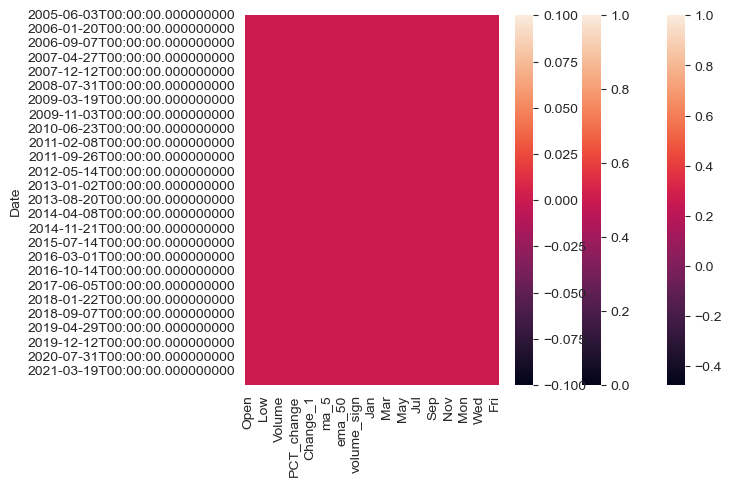

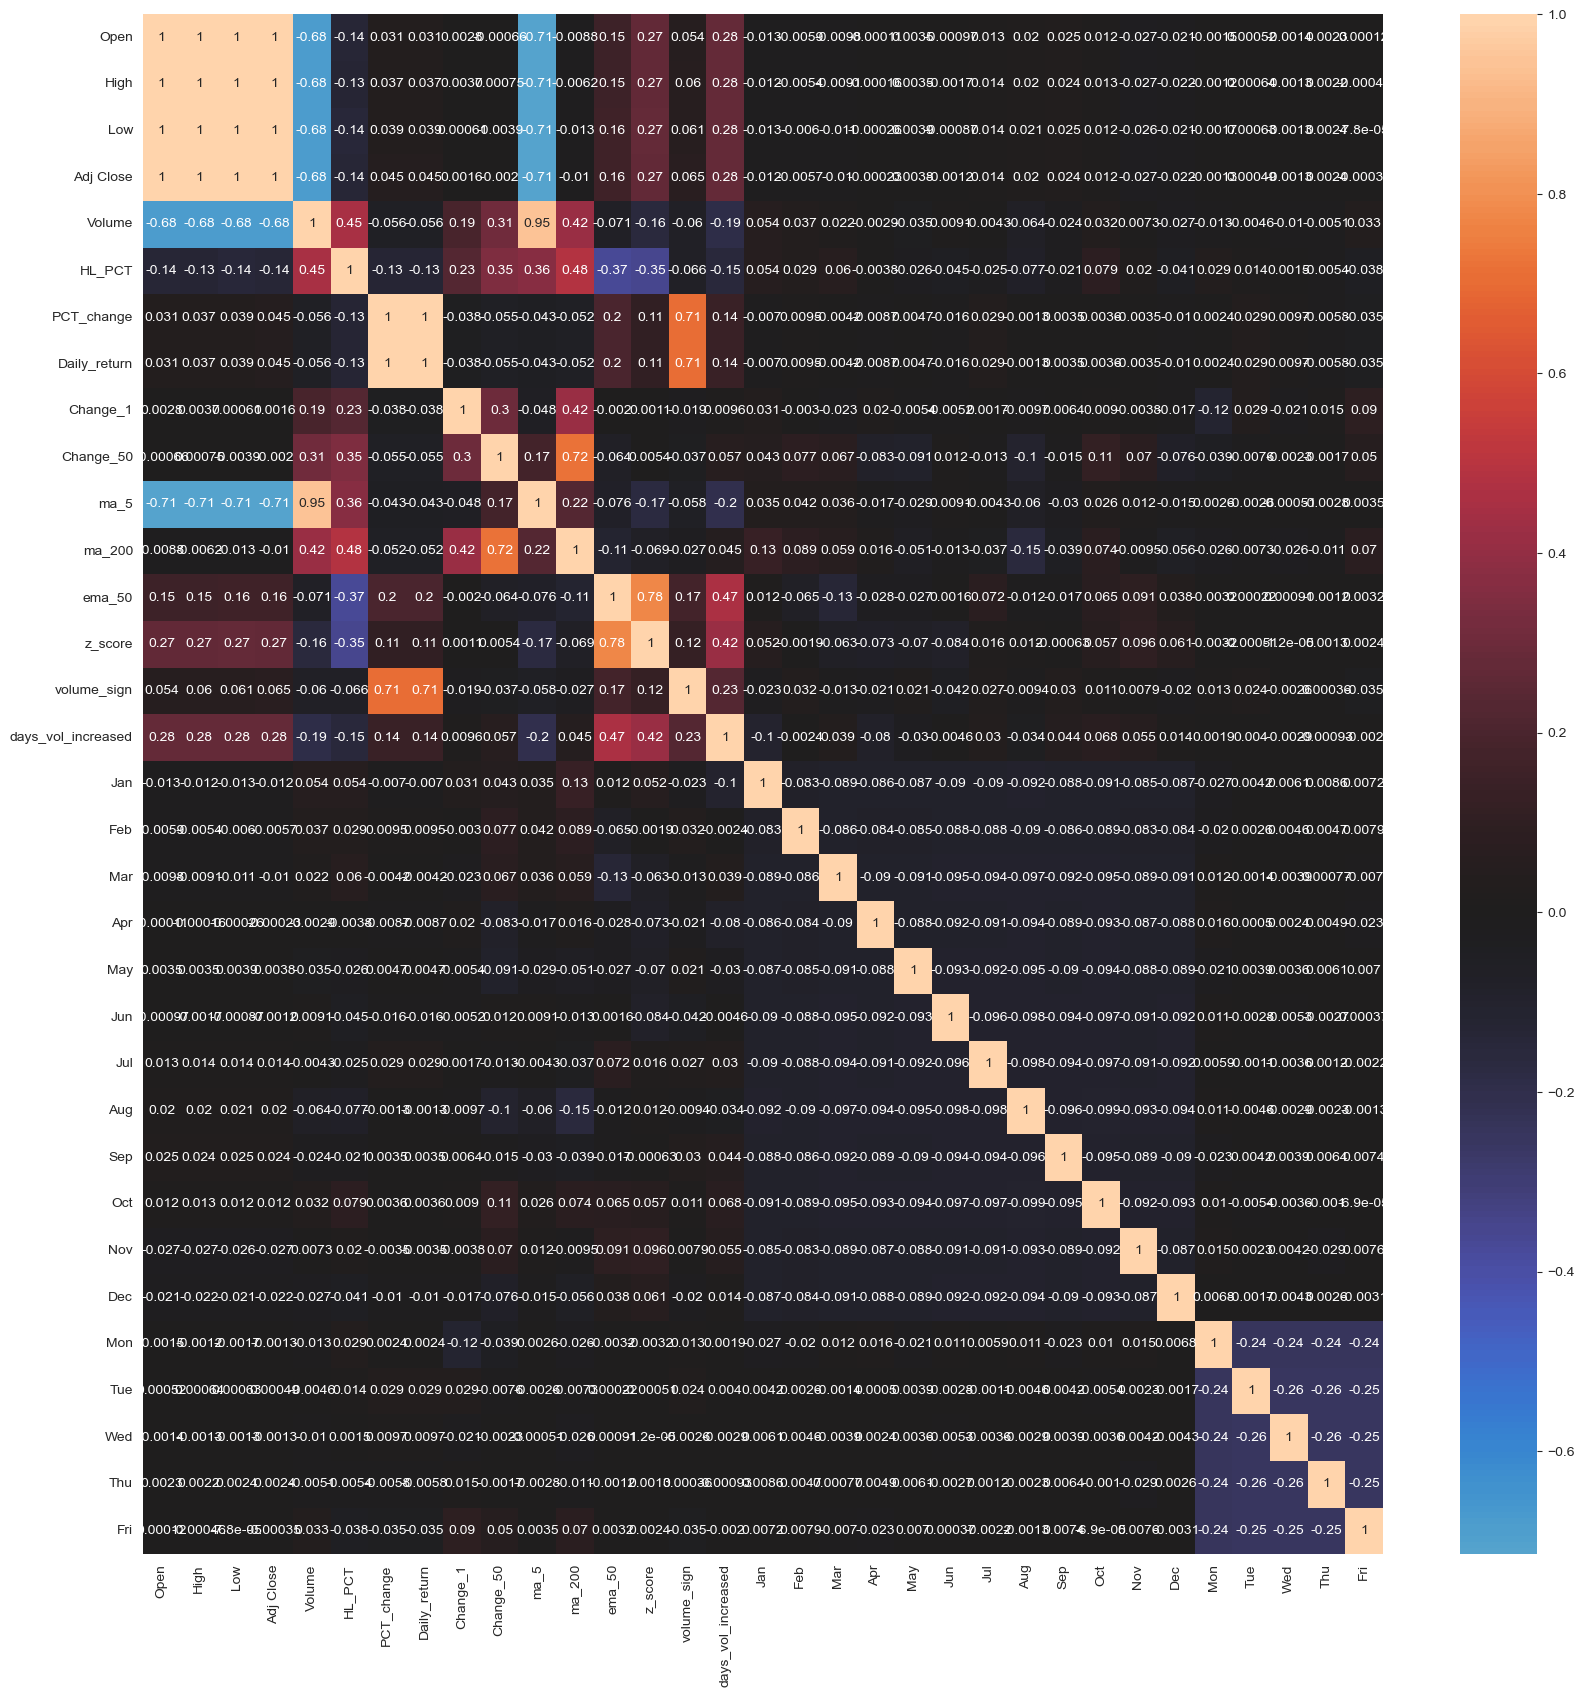

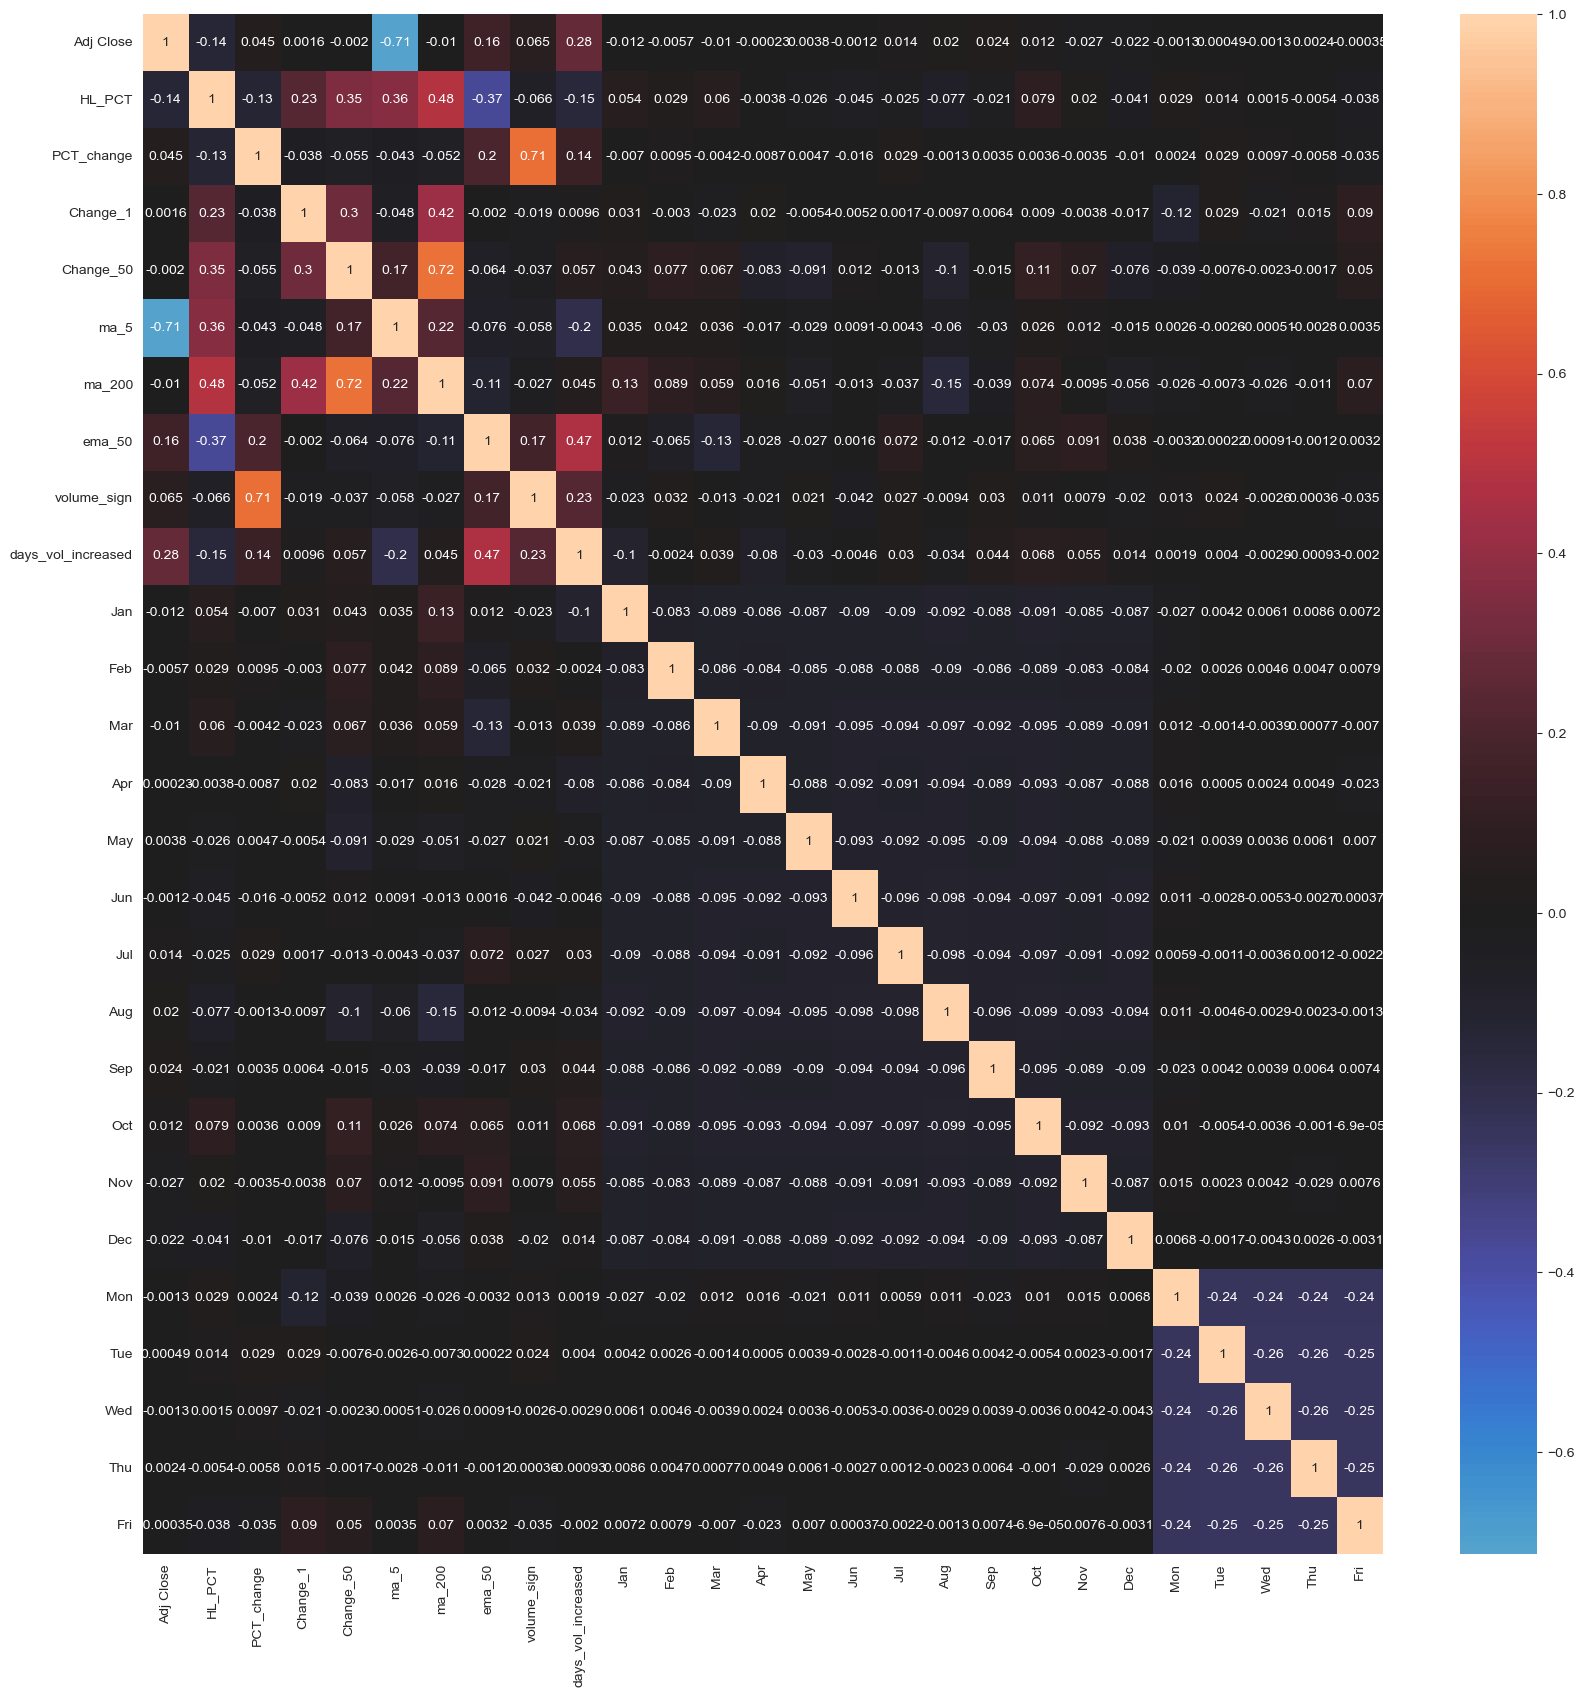

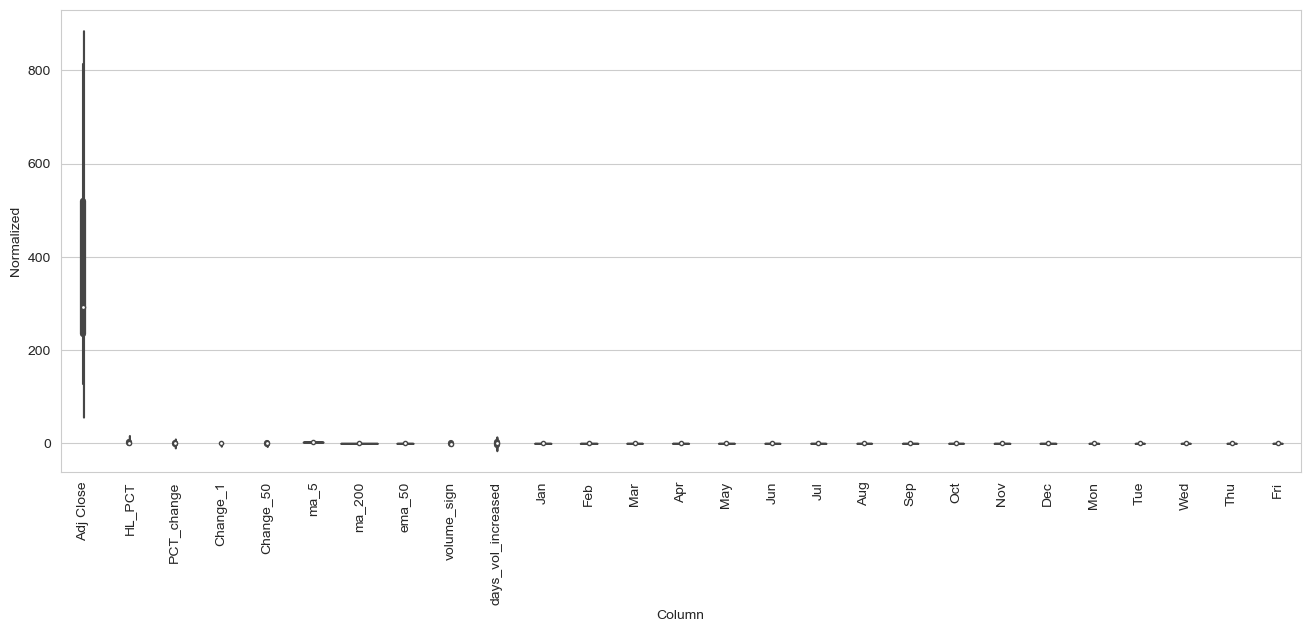

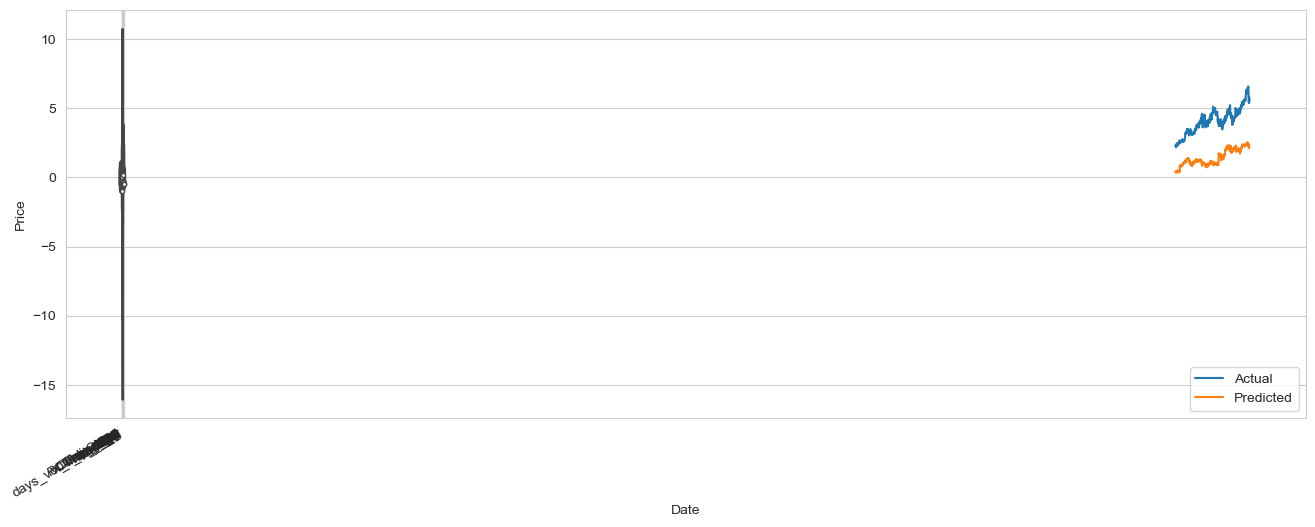

In [24]:
df_val['Adj Close'].plot(label='Actual')
predictions_baseline['Adj Close'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Conclusion: The predictions for baseline model are quite poor with a mean absolute percentage error close to 40%. This is expected as the stockmarket has an upward trend and most successful companies see a growth over the year. Let's see how we can make it better.

### Keep it simple, keep it linear

In [25]:
# get the number steps to predict
OUT_STEPS = int(input())

 7


#### N-day forecast

In [26]:
def train_test_split_nday_forecast(df_train=df_train, df_val=df_val):
    """
    Splits both the training and validation sets into X and Y
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    :return:
        X_train:ndarray
            all training features
        X_val: ndarray
            all validation features
        y_train: ndarray
            training output variable
        y_val: ndarray
            validation output variable

    """
    
    df_temp_train = df_train.copy()
    df_temp_train['label'] = df_temp_train['Adj Close'].shift(-OUT_STEPS)
    df_temp_train = df_temp_train.dropna()

    df_temp_val = df_val.copy()
    df_temp_val['label'] = df_temp_val['Adj Close'].shift(-OUT_STEPS)
    df_temp_val =  df_temp_val.dropna()
    
    # Get X
    X_train = np.array(df_temp_train.drop(columns=['label']))
    X_val = np.array(df_temp_val.drop(columns=['label']))
    
    y_train = np.array(df_temp_train['label'])
    y_val = np.array(df_temp_val['label'])

    return X_train, X_val, y_train, y_val

##### Linear Regression

In [27]:
def linear_reg_n_day(df_train=df_train, df_val=df_val):
    """
    Initializes and fits Linear regression classfier   
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    :return:
        predictions: ndarray
            predicted values
            
    """
    # Get train test data
    X_train, X_val, y_train, y_val = train_test_split_nday_forecast(df_train, df_val)
    
    # Create a classifier
    clfreg = LinearRegression()
    clfreg.fit(X_train, y_train)

    predictions = clfreg.predict(X_val)

    print(clfreg.score(X_val, y_val))
    
    compute_errors(y_val, predictions)
    
    return predictions

In [28]:
predictions = linear_reg_n_day()

0.9350205900756291
Mean squared error of a linear model is  0.0545130562816361
Root mean squared error of a linear model is  0.2334803124069267
Mean absolute percentage error of a linear model is  0.04372130084507769


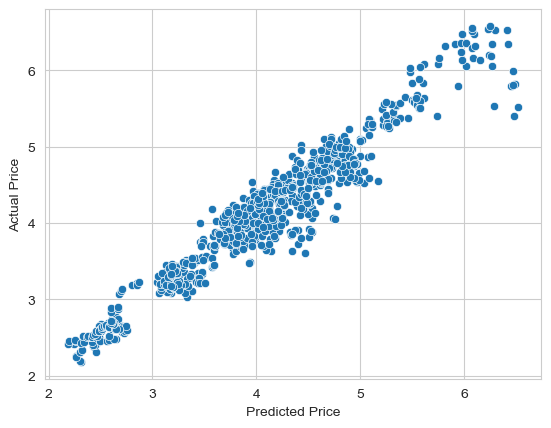

In [29]:
_, _, _, y_val = train_test_split_nday_forecast()
sns.scatterplot(x=predictions, y=y_val)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

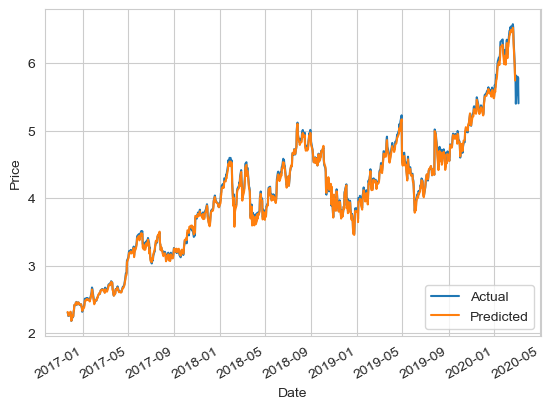

In [30]:
predictions_lin_reg = pd.DataFrame(data=predictions, columns=['Predicted'], index=df_val.index[:-OUT_STEPS])

df_val['Adj Close'].plot(label='Actual')
predictions_lin_reg['Predicted'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

##### Polynomial regression (n^2) 

In [31]:
def quadratic_reg_n_day(df_train=df_train, df_val=df_val):
    """
    Initializes and fits Polynimoal regression classfier 
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    :return:
        predictions: ndarray
            predicted values
    """
    
    # Get train test data
    X_train, X_val, y_train, y_val = train_test_split_nday_forecast(df_train, df_val)
    
    clfpoly = make_pipeline(PolynomialFeatures(2), Ridge())
    clfpoly.fit(X_train, y_train)
    
    predictions = clfpoly.predict(X_val)

    print(clfpoly.score(X_val, y_val))
    
    compute_errors(y_val, predictions)
    
    return predictions

0.9166864721591308
Mean squared error of a linear model is  0.06989406394267014
Root mean squared error of a linear model is  0.26437485497427726
Mean absolute percentage error of a linear model is  0.048940790278779824


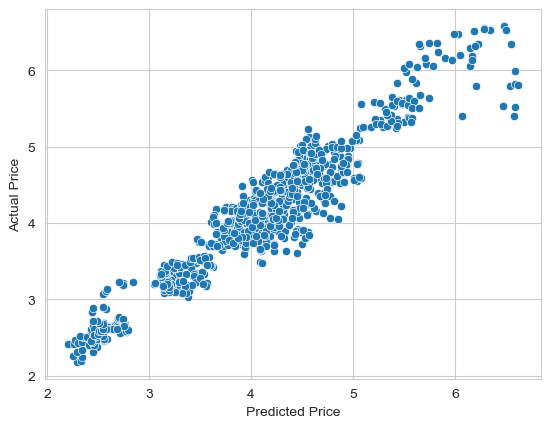

In [32]:
predictions_quad = quadratic_reg_n_day()

_, _, _, y_val = train_test_split_nday_forecast()

sns.scatterplot(x=predictions_quad, y=y_val)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

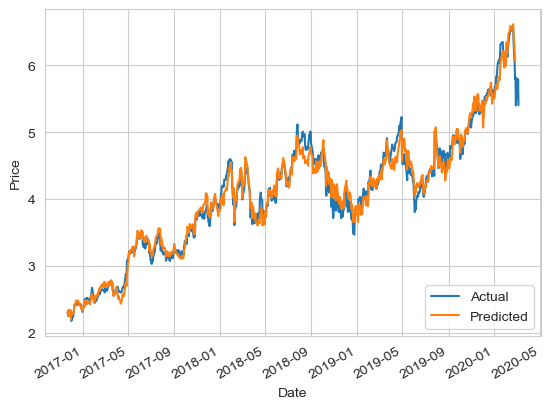

In [33]:
predictions_quad_reg = pd.DataFrame(data=predictions_quad, columns=['Predicted'], index=df_val.index[:-OUT_STEPS])

df_val['Adj Close'].plot(label='Actual')
predictions_quad_reg['Predicted'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### k-Nearest Neighbors

In [34]:
def get_k_knn(X_train, X_val, y_train, y_val):
    """ 
    Returns the optimal number of nearest neighbors 
    
    :params:
        X_train: ndarray
            all training features
        X_val: ndarray
            all validation features
        y_train: ndarray
            training output variable
        y_val: ndarray
            validation output variable
        
    :return:
        n_neighbors: int
            optimal number of nearest neighbors
    """
    # genereate number of NN from 1 to 100
    k = [i for i in range(1,100)]
    mape = []
    
    # fit classifier 100 times
    for i in k:
        clfknn = KNeighborsRegressor(n_neighbors=i)
        clfknn.fit(X_train, y_train)
        predictions_knn = clfknn.predict(X_val)

        mape.append(mean_absolute_percentage_error(y_val, predictions_knn))

    # choose the optimal number of NN
    n_neighbors = mape.index(min(mape)) + 1
    
    return n_neighbors

In [35]:
def knn_n_days():
    """
    Initializes and fits k-Nearest Neighbors Classifier
    
    :params:
        None
        
    :return:
        predictions: ndarray
            predicted values
    
    """
    # get the data
    X_train, X_val, y_train, y_val = train_test_split_nday_forecast()
    
    n_neighbors = get_k_knn(X_train, X_val, y_train, y_val)
    
    # KNN Regression
    clfknn = KNeighborsRegressor(n_neighbors=n_neighbors,)
    clfknn.fit(X_train, y_train)

    # prediction
    predictions_knn = clfknn.predict(X_val)
    
    print('R2 is', clfknn.score(X_val, y_val))
    compute_errors(y_val, predictions_knn)
    
    return predictions_knn

R2 is -5.2816288727408685
Mean squared error of a linear model is  5.269835301345856
Root mean squared error of a linear model is  2.2956121844392308
Mean absolute percentage error of a linear model is  0.4919579528976605


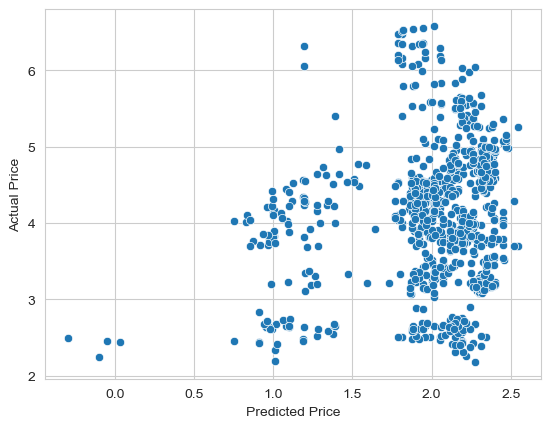

In [36]:
predictions_knn = knn_n_days()
    
sns.scatterplot(x=predictions_knn, y=y_val)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

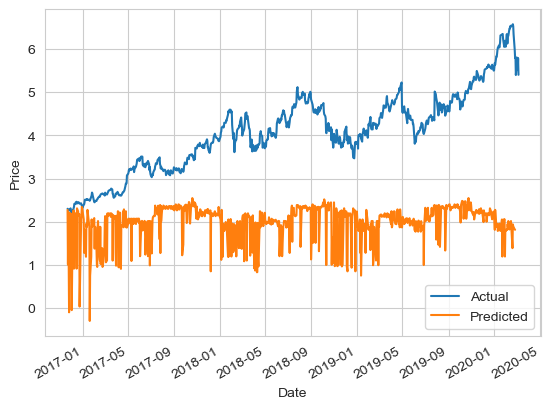

In [37]:
predictions_knn_df = pd.DataFrame(data=predictions_knn, columns=['Predicted'], index=df_val.index[:-OUT_STEPS])

df_val['Adj Close'].plot(label='Actual')
predictions_knn_df['Predicted'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

As we can see, metrics for KNN are much worse then those of a quadratic function. KNN failed to predict an upward trend.

---
### TensorFlow

*Source: https://www.tensorflow.org/tutorials/structured_data/time_series*

#### Data windowing 

![title](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png)

In [38]:
# input_width -> history size
# shift -> prediction of 'shift' days into the future
# label_width -> number of predictions

class WindowGenerator():
    """
    A class to represent a window object.

    :attr:
        input_width: int
            number of time steps considered in input
        label_width: int
            number of time steps to be predicted
        shift: int
            the time offset between input and label windows
        X_train: ndarray
            all training features
        X_val: ndarray
            all validation features
        y_train: ndarray
            training output variable
        y_val: ndarray
            validation output variable

    methods:
        __repr__():
            Returns a string representing window object

    """
    def __init__(self, input_width, label_width, shift,
                 train_df=df_train, val_df=df_val, test_df=df_test,
                 label_columns=None):
        """
        Constructs all the necessary attributes for the Window object.

        :params:
            name : str
                first name of the person
            surname : str
                family name of the person
            age : int
                age of the person
                
        :returns:
            None
            
        """
        
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices
        self.label_columns = label_columns
        
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Work out the window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        """
        Returns a string representing window object
        """
        
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

In [39]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=1, label_columns=['Adj Close'])
w1

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Adj Close']

#### Split

In [40]:
def split_window(self, features):
    """
    Given a list of consecutive inputs, convert them to a window of inputs and a window of labels.

    :params:
        features: tf tensor
            window object
            
    :return:
        inputs: tf tensor
            tensor of inputs
        labels: tf tensor
            tensor of labels

    """
    
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack([
            labels[:, :, self.column_indices[name]] for name in self.label_columns
        ], axis=-1)
    
    # preserve the shape of the input
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
        

In [41]:
# add split_window method as a method on WindowGenerator class
WindowGenerator.split_window = split_window

In [42]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(df_train[:w1.total_window_size]),
                           np.array(df_train[100:100+w1.total_window_size]),
                           np.array(df_train[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

w1.example = example_inputs, example_labels

#### Visualization of a split window

In [43]:
def plot(self, model=None, plot_col='Adj Close', max_subplots=10):
    """
    This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to.
    
    :params:
        model: tf
            ml model
        plot_col: str
            name of the column to be ploted
        max_subplots: int
            maximum number of subplots
            
    :return:
        None
    
    """
    inputs, labels = self.example
    
    plt.figure(figsize=(12, 16))
    plot_col_index = self.column_indices[plot_col]
    
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                   edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
        
        if n == 0:
            plt.legend()
            
    plt.xlabel('Time [D]')
    
# add plot as a method on WindowGenerator object
WindowGenerator.plot = plot

In [44]:
w1.plot()

#### Create tf.data.Datasets

In [45]:
def make_dataset(self, data):
    """
    Takes a time series DataFrame and converts it to a tf.data.Dataset of (input_window, label_window) pairs 
    using the preprocessing.timeseries_dataset_from_array function
    
    :params:
        data: DataFrame
            time series data
                    
    :return:
        ds: tf.data.Dataset
            time series data 
    
    """
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    
    return ds

# add make_dataset method to a WindowGenerator object
WindowGenerator.make_dataset = make_dataset
    

In [46]:
# Add properties for accessing them as tf.data.Datasets using the make_dataset method defined earlier
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """
    Get and cache an example batch of `inputs, labels` for plotting.
    """
    result = getattr(self, '_example', None)
    
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
        
    return result
        
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


#### Prediction

In [47]:
multi_window = WindowGenerator(input_width=OUT_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS, 
                               label_columns=['Adj Close'])
multi_window
multi_window.plot()

#### Baselines
Baseline 1: repeat the last input time step for the required number of output time steps

In [48]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    A class to represent a simple multi step baseline model.
            
    methods:
        call(inputs):
            Returns the last input time step for the required number of output time steps.
    """
    def call(self, inputs):
        """
        Returns the last input time step for the required number of output time steps.
        
        :params: tf tensor
        inputs: input to the model
        
        :return: tf tensor
            The last input time step for the required number of output time steps.
            
        """
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])


last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                     metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

26/26 [==============================] - 0s 786us/step - loss: 18.2018 - mean_absolute_error: 3.9961


Baseline 2: repeat the previous day, assuming tomorrow will be similar

In [49]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

26/26 [==============================] - 0s 769us/step - loss: 18.2077 - mean_absolute_error: 3.9982


#### Single-shot models: Linear
Single-shot model makes the entire sequence prediction in a single step.

In [50]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=500, label_width=OUT_STEPS, shift=OUT_STEPS, 
                               label_columns=['Adj Close'])
multi_window
multi_window.plot()

In [51]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=patience,
                                                      mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [70]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), 
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

22/22 [==============================] - 0s 1ms/step - loss: 0.5683 - mean_absolute_error: 0.4755


In [53]:
print('Linear Model:', multi_val_performance['Linear'])
print('Baseline Repeat: ', multi_val_performance['Repeat'])
print('Baseline Last: ', multi_val_performance['Last'])

Linear Model: [1.1447160243988037, 1.0186519622802734]
Baseline Repeat:  [18.207714080810547, 3.998222589492798]
Baseline Last:  [18.201826095581055, 3.9960689544677734]


As we can see, Linear model does better than either baseline, but it is not great. We can try adding more Dense layers but it will still be bases on a single input time step. 

#### Single-shot models: Dense

In [72]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

22/22 [==============================] - 0s 2ms/step - loss: 0.5262 - mean_absolute_error: 0.4587


In [55]:
print('Linear Model:', multi_val_performance['Linear'])
print('Dense Model:', multi_val_performance['Dense'])

Linear Model: [1.1447160243988037, 1.0186519622802734]
Dense Model: [0.1246456727385521, 0.27624425292015076]


We've got the improved performance but the result is not satisfying. We can try using CNN that is based on a fixed-width history. This should lead to a better performance since CNN can see how things are changing over time.

#### Single-shot model: CNN

In [73]:
%%time
CONV_WIDTH = 3

multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


22/22 [==============================] - 0s 1ms/step - loss: 0.5751 - mean_absolute_error: 0.5352
CPU times: user 17.5 s, sys: 6.44 s, total: 24 s
Wall time: 6.6 s


In [57]:
print('Dense Model:', multi_val_performance['Dense'])
print('CNN Model:', multi_val_performance['Conv'])

Dense Model: [0.1246456727385521, 0.27624425292015076]
CNN Model: [0.2793971300125122, 0.45682471990585327]


CNN did perform better than the Dense model. Let's see if we can improve the prediction by using RNN.

#### Single-shot model: RNN

In [58]:
%%time
multi_window = WindowGenerator(input_width=100,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(128, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


22/22 [==============================] - 1s 23ms/step - loss: 0.4909 - mean_absolute_error: 0.4666
CPU times: user 4min 49s, sys: 1min 38s, total: 6min 27s
Wall time: 1min 54s


In [59]:
print('CNN Model:', multi_val_performance['Conv'])
print('LSTM Model:', multi_val_performance['LSTM'])

CNN Model: [0.2793971300125122, 0.45682471990585327]
LSTM Model: [0.4908995032310486, 0.46659207344055176]


#### Autoregressive: RNN

In [60]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)

In [61]:
def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [62]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 27])

In [63]:
def call(self, inputs, training=None):
    predictions = []
    
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)
    predictions.append(prediction)
    
    for n in range(1, self.out_steps):
        x = prediction
        x, state= self.lstm_cell(x, states=state, training=training)
        
        prediction = self.dense(x)
        predictions.append(prediction)
        
    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    
    return predictions


FeedBack.call = call

In [64]:
%%time
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)


22/22 [==============================] - 0s 11ms/step - loss: 0.7405 - mean_absolute_error: 0.6005
CPU times: user 56.2 s, sys: 12.3 s, total: 1min 8s
Wall time: 29.7 s


In [65]:
print('CNN Model:', multi_val_performance['Conv'])
print('RNN Model:', multi_val_performance['LSTM'])
print('AR RNN Model:', multi_val_performance['AR LSTM'])

CNN Model: [0.2793971300125122, 0.45682471990585327]
RNN Model: [0.4908995032310486, 0.46659207344055176]
AR RNN Model: [0.7404970526695251, 0.6005423069000244]


#### Performance

In [68]:
multi_performance

{'Last': [88.0117416381836, 8.696449279785156],
 'Repeat': [87.98454284667969, 8.697163581848145],
 'Linear': [],
 'Dense': [],
 'Conv': [],
 'LSTM': [2.3041975498199463, 0.8480997085571289],
 'AR LSTM': [2.9563229084014893, 0.9332953691482544]}

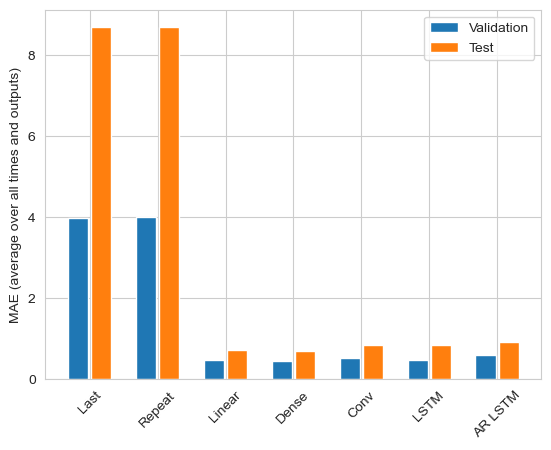

In [78]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

plt.show()

***Conclusion***: It seems like there is not a big difference between the last 5 models.
I think that LSTM should be more robust to new data samples, therefore I will use this model to make the prediction. 

In [80]:
multi_lstm_model.save('lstm_model')

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets
